# Предсказание распределений вина по классам

In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Загрузим классический учебный набор данных `load_wine()` с информацией о винах, следующей структуры:

* Classes: 3
* Samples per class: [59,71,48]
* Samples total: 178
* Dimensionality: 13
* Features: real, positive

In [3]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()

Посмотрим на его размерность:

In [4]:
wine.data.shape

(178, 13)

Разделим данные на тренировочные и проверочные и переведём их в тензоры:

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Создадим класс для нейронной сети: она будет состоять из входного слоя, функции активации сигмоды, скрытого слоя также с функцией активации сигмодой, выходного слоя с последующим переводом в вероятность при помощи функции softmax.

In [30]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

Создадим экземпляр класса с пятью нейронами на скрытом слое:

In [31]:
wine_net = WineNet(n_hidden_neurons=5)

Определим функцию потерь через кросс-энтропию, а в качестве оптимизатора возьмём Adam с шагом обучения 0,001.

In [32]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr = 0.001)

Обучим нашу нейронную сеть:

In [33]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net(x_batch)
        loss_value = loss(preds, y_batch)
        
        loss_value.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.2407)
tensor(0.4815)
tensor(0.4815)
tensor(0.4815)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5000)
tensor(0.5370)
tensor(0.7222)
tensor(0.7037)
tensor(0.6852)
tensor(0.6852)
tensor(0.6852)
tensor(0.7222)
tensor(0.7222)
tensor(0.7037)
tensor(0.7222)
tensor(0.7407)
tensor(0.7778)
tensor(0.7778)
tensor(0.7963)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)


Выведем полученные результаты в виде закрашенных множеств:

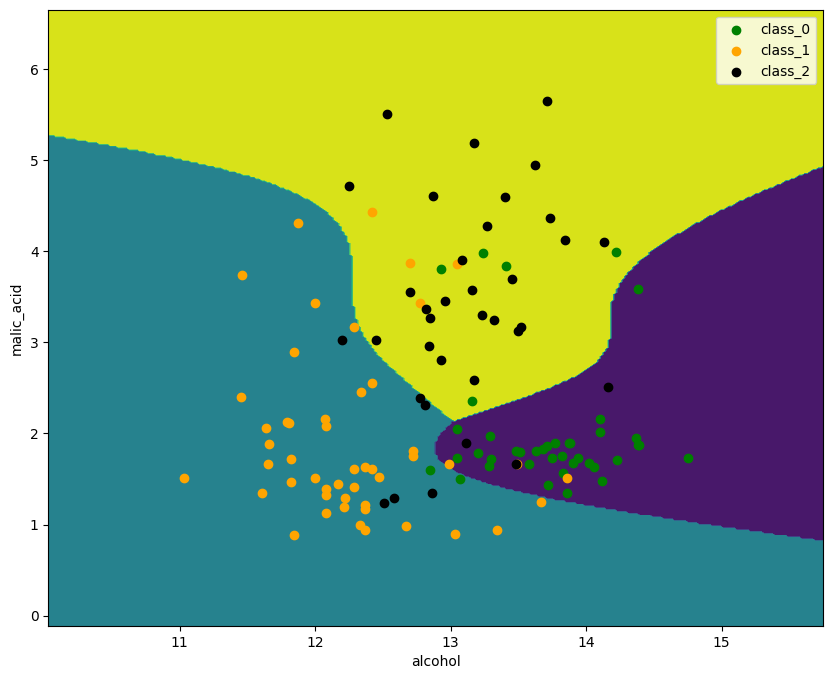

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class)

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i])
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

Задание$^*$: построить ROC-кривую для этого множества. 

In [88]:
def roc_curve(y_true, y_scores):
    # Сортируем предсказанные вероятности и соответствующие метки
    thresholds = np.sort(np.unique(y_scores))[::-1]  # Уникальные пороги в порядке убывания
    tpr = []  # True Positive Rate
    fpr = []  # False Positive Rate

    P = np.sum(y_true == 1)  # Количество положительных примеров
    N = np.sum(y_true == 0)  # Количество отрицательных примеров

    for threshold in thresholds:
        # Применяем порог для классификации
        y_pred = (y_scores >= threshold).astype(int)

        TP = np.sum((y_pred == 1) & (y_true == 1))  # True Positives
        FP = np.sum((y_pred == 1) & (y_true == 0))  # False Positives
        
        tpr.append(TP / P if P > 0 else 0)  # True Positive Rate
        fpr.append(FP / N if N > 0 else 0)  # False Positive Rate

    return np.array(fpr), np.array(tpr), thresholds


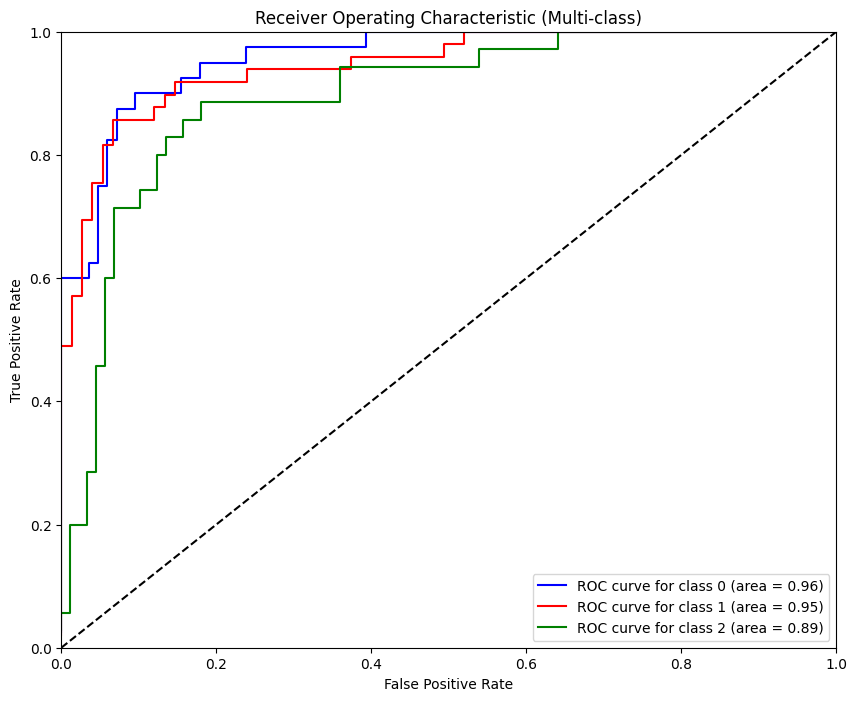

In [103]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

y_scores = wine_net.inference(X_train).detach().numpy() # Вероятности классов
n_classes = 3
y_true_bin = label_binarize(y_train, classes=[0, 1, 2]) # Бинаризация истинных классов, т.е. (0) -> (1, 0, 0)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Линия случайного угадывания
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc='lower right')
plt.show()